In [67]:
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import math
import os
import pandas as pd
from torchvision.io import read_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [68]:
# Check compute device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [69]:
split_rate = 0.8
batch_size = 32
epochs = 50
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()


In [70]:

data_path = "./images"
#Transform images 
data_transforms = transforms.Compose([transforms.Resize((150, 150)), 
                                      transforms.RandomRotation(10), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ToTensor()])
#Split data
dataset1 = torchvision.datasets.ImageFolder(root=data_path, transform=data_transforms)
dataset = torch.utils.data.Subset(dataset1,range(int(0.1*len(dataset1))))
train_dataset = torch.utils.data.Subset(dataset,range(int(split_rate*len(dataset))))
test_dataset = torch.utils.data.Subset(dataset, range(int((1 - split_rate)*len(dataset)), len(dataset)))

In [71]:
def show_transformed_images(Dataset):
    loader = torch.utils.data.DataLoader(Dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    #show images after transform
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print("Labels: ", labels)


Labels:  tensor([3, 7, 3, 3, 3, 3])


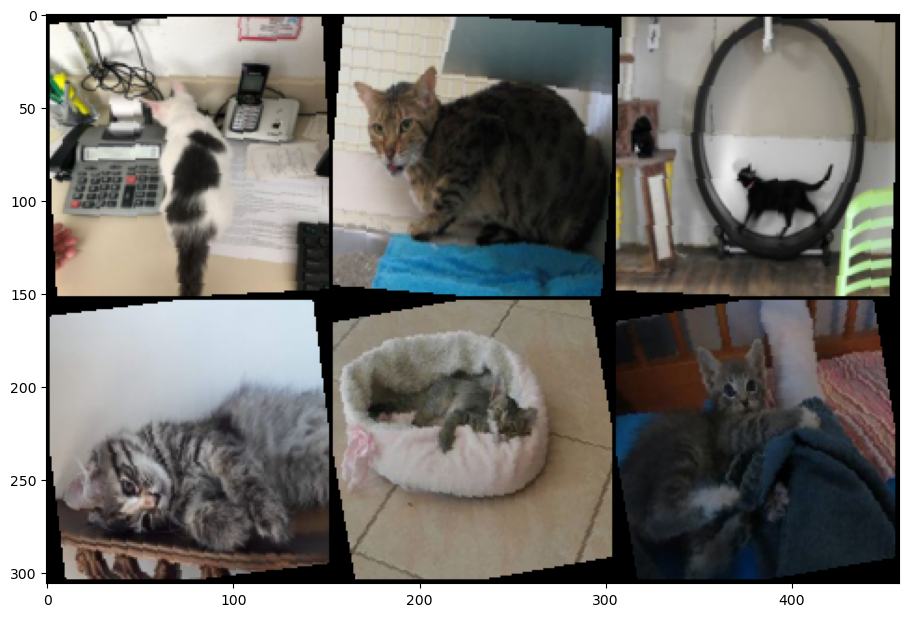

In [72]:
#Show some images
show_transformed_images(train_dataset)

In [73]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [74]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.CNN = nn.Sequential(
            # 150*150*3
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            # 150*150*32
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            # 75*75*32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(128),
            # 75*75*64
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(256),
            nn.MaxPool2d(2, stride=2),
            
            # 37*37*64
            nn.Flatten(),
            # 37*37*64
            nn.Dropout(0.5),
            nn.Linear(37*37*64, 1024),

            nn.Dropout(0.4),
            nn.Linear(1024,512),

            nn.Dropout(0.2),
            nn.Linear(512, 67),
           
            

        )
        

    def forward(self, x):
        return self.CNN(x)
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [75]:
def evaluate(model, test_dataloader,criterion):
    model.eval()
    corrects_per_epoch = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predict = torch.max(outputs.data, 1)

            

            running_loss += loss.item()
            corrects_per_epoch += (labels == predict).sum().item()
    epoch_loss = running_loss/len(test_dataloader)
    epoch_acc = 100.00 * corrects_per_epoch / total
    print("Test acc: %.3f%%, Test loss: %.3f" % (epoch_acc, epoch_loss))
            


In [76]:

def train_NN(model, train_dataloader, test_dataloader, criterion, optimizer, number_epochs):
    
    for epoch in range(number_epochs):
        print("Epochs number %d" % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        for data in train_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
           

            outputs = model(images)
            _, predict = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            running_loss += loss.item()
            running_correct += (labels == predict).sum().item()
        epoch_loss = running_loss/len(train_dataloader)
        epoch_acc = 100.00 * running_correct / total
        print("Training complete. Got %d out of %d correctly (%.3f%%). Epoch loss: %.3f" % (running_correct, total, epoch_acc, epoch_loss))

        evaluate(model, test_dataloader, criterion)
        #model.save("My_model")
    print("Finished")
    return model


In [77]:
train_NN(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

Epochs number 1
Training complete. Got 4924 out of 10128 correctly (48.618%). Epoch loss: 1.653
Test acc: 41.060%, Test loss: 2.333
Epochs number 2
Training complete. Got 5183 out of 10128 correctly (51.175%). Epoch loss: 1.469
Test acc: 41.060%, Test loss: 2.340
Epochs number 3
Training complete. Got 5253 out of 10128 correctly (51.866%). Epoch loss: 1.457
Test acc: 41.060%, Test loss: 2.486
Epochs number 4
Training complete. Got 5261 out of 10128 correctly (51.945%). Epoch loss: 1.450
Test acc: 41.060%, Test loss: 2.539
Epochs number 5
Training complete. Got 5267 out of 10128 correctly (52.004%). Epoch loss: 1.448
Test acc: 41.060%, Test loss: 2.338
Epochs number 6


KeyboardInterrupt: 